### OPTIMISING A PERFORMANCE METRIC

**1. Using user defined performance metric**
- Here we are going to optimize a metric in a grid search for hyperparameters using a scoring function we define

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer

In [4]:
breast_cancer_X, breast_cancer_y = load_breast_cancer(return_X_y=True)
X = pd.DataFrame(breast_cancer_X)
y = pd.Series(breast_cancer_y).map({0:1, 1:0})

X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
# let's see the proportion of 0s and 1s
y.value_counts()/len(y)

0    0.627417
1    0.372583
dtype: float64

In [13]:
def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return fn/(tp + fn)

In [14]:
fnr_score = make_scorer(
    fnr,
    greater_is_better=False, #smaller_is_better
    needs_proba=False
)

In [15]:
# random forests
rf_model = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0, n_jobs=4) #n_jobs=-1 to allow my computer use all processors for parallel computing)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4]
)

#search
clf = GridSearchCV(rf_model, rf_param_grid, scoring=fnr_score, cv=5)

search = clf.fit(X,y)

# best hyper parameters
search.best_params_

{'max_depth': 3, 'n_estimators': 200}

In [18]:
# create a dataframe of the results of the hyper parameter tuning
results = pd.DataFrame(search.cv_results_).loc[:, ['params', 'mean_test_score', 'std_test_score']]

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",-0.164563,0.068712
1,"{'max_depth': 1, 'n_estimators': 20}",-0.159801,0.073267
2,"{'max_depth': 1, 'n_estimators': 50}",-0.178627,0.068895
3,"{'max_depth': 1, 'n_estimators': 100}",-0.145404,0.085822
4,"{'max_depth': 1, 'n_estimators': 200}",-0.140642,0.082462


Text(0.5, 0, 'Hyperparameter space')

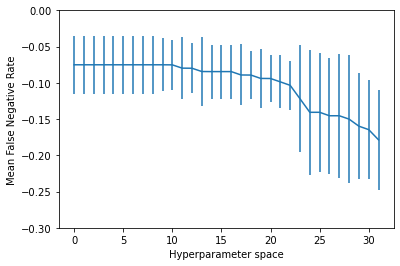

In [ ]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylim(-0.3, 0)
plt.ylabel('Mean False Negative Rate')
plt.xlabel('Hyperparameter space')

- in the x asis we find all the different machine learning models that were trained with the different hyper parameters, which we sorted from best to worse score
- We notice the mean FNR has been negated in the y-axis because we are trying to maximise that value
- the bars are the error rates provided by 5-fold cross validation

### 4. Scoring Function that needs a probability

Scikit learn automatically classifies a record as 1 if y_probability > 0.5 and 0 otherwise. What if we want to change the threshold probability so that a record is only classified as 1 (malign tumor) based on a threshold probability of 0.37

In [23]:
def fnr(y_true, y_pred):
    y_pred_class =np.where(y_pred > 0.37, 1,0) #this better represents the distribution of the class in the data
    
    tn, fb, fn, tp = confusion_matrix(y_true, y_pred_class, labels=[0,1]).ravel()
    
    return fn/(tp + fn)

In [26]:
fnr_score = make_scorer(
    fnr,
    greater_is_better=False, #False because we want to minimise this value. smaller_is_better
    needs_proba=True #True here because we want to take the probability and determine the class
)

In [29]:
# random forests
rf_model = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0, n_jobs=4) #n_jobs=-1 to allow my computer use all processors for parallel computing)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4]
)

#search
clf = GridSearchCV(rf_model, rf_param_grid, scoring=fnr_score, cv=5)

search = clf.fit(X,y)

# best hyper parameters
search.best_params_

{'max_depth': 4, 'n_estimators': 500}

Text(0.5, 0, 'Hyperparameter space')

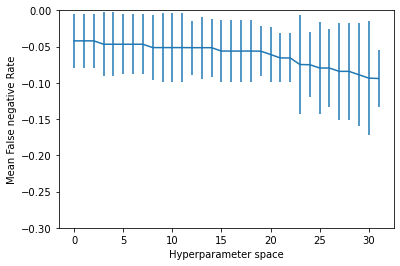

In [31]:
# Let's plot the mean test score over the number of models
results = pd.DataFrame(search.cv_results_).loc[:, ['params', 'mean_test_score', 'std_test_score']]

results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylim(-0.3, 0)
plt.ylabel('Mean False negative Rate')
plt.xlabel('Hyperparameter space')

Notice:
- We obtain a slightly better FNR just by modifying the scoring function using a probability threshold that better represents the distribution of the class in the data.

**2. Using sklearn scoring function**

Here, we are going to see how we can optimize a metric in a grid search for hyper parameters using scoring sklearn

In [35]:
# random forests
rf_model = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0, n_jobs=4) #n_jobs=-1 to allow my computer use all processors for parallel computing)

# hyperparameter space
rf_param_grid = dict(
    n_estimators=[10, 20, 50, 100, 200, 500, 1000, 2000],
    max_depth=[1, 2, 3, 4]
)

#search
clf = GridSearchCV(rf_model, 
                   rf_param_grid, 
                   scoring='roc_auc', #instead of passing a function, we pass a string representing the sklearn function we want to optimize
                   cv=5)

search = clf.fit(X,y)

# best hyper parameters
search.best_params_

{'max_depth': 3, 'n_estimators': 50}

the rest of the notebook is identical

In [37]:
results = pd.DataFrame(search.cv_results_).loc[:, ['params', 'mean_test_score', 'std_test_score']]

results.head()

,params,mean_test_score,std_test_score
0,"{'max_depth': 1, 'n_estimators': 10}",0.976634,0.018081
1,"{'max_depth': 1, 'n_estimators': 20}",0.982221,0.014463
2,"{'max_depth': 1, 'n_estimators': 50}",0.984714,0.010529
3,"{'max_depth': 1, 'n_estimators': 100}",0.985032,0.009164
4,"{'max_depth': 1, 'n_estimators': 200}",0.984932,0.009091


Text(0.5, 0, 'Hyperparameter space')

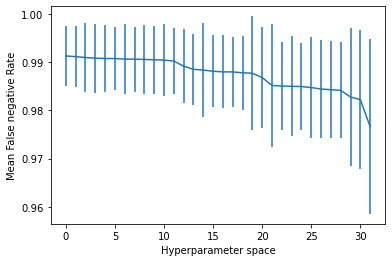

In [39]:
# Let's plot the mean test score over the number of models
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean False negative Rate')
plt.xlabel('Hyperparameter space')

https://scikit-learn.org/stable/modules/model_evaluation.html

In [3]:
string = '2022-02-01 scheduled-background-job-runner-1 bacgrounder: INFO com.tableau'

In [4]:
re.findall(r'(\w+-)

SyntaxError: EOL while scanning string literal (990113945.py, line 1)

In [2]:
help(re)

Help on module re:

NAME
    re - Support for regular expressions (RE).

MODULE REFERENCE
    https://docs.python.org/3.9/library/re
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    This module provides regular expression matching operations similar to
    those found in Perl.  It supports both 8-bit and Unicode strings; both
    the pattern and the strings being processed can contain null bytes and
    characters outside the US ASCII range.
    
    Regular expressions can contain both special and ordinary characters.
    Most ordinary characters, like "A", "a", or "0", are the simplest
    regular expressions; they simply match themselves.  You can
    concatenate ordinary characters, so last mat